# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from timeit import timeit
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 4
    IMAGES_PER_GPU = 8
    
    LEARNING_RATE = 0.01

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 300

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     32
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      4
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         20

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
TRAIN_PATH = '/home/yuchenkai/nuclei_data/stage1_train/'
TEST_PATH = '/home/yuchenkai/nuclei_data/stage1_test/'
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Load train images and masks
print('Loading train images and masks ... ')
sys.stdout.flush()
images = []
masks = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :config.IMAGE_SHAPE[-1]]
    # print(img.shape)
    images.append(img)
    
    mask = []
    for m_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
        msk = imread(path + '/masks/' + mask_file)
        mask.append(msk)
    mask = np.array(mask).transpose((1, 2, 0))
    # print(mask.shape)
    masks.append(mask)

# split validation set from training set
split = int(len(images) * 0.9)
images_train = images[:split]
masks_train = masks[:split]
images_val = images[split:]
masks_val = masks[split:]

Loading train images and masks ... 


100%|██████████| 670/670 [02:25<00:00,  4.61it/s]


In [5]:
# Load test images
print('Loading test images ... ')
sys.stdout.flush()
images_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :config.IMAGE_SHAPE[-1]]
    images_test.append(img)

Loading test images ... 


100%|██████████| 65/65 [00:00<00:00, 80.65it/s]


In [6]:
class ShapesDataset(utils.Dataset):
    
    def __init__(self, height, width):
        super(ShapesDataset, self).__init__()
        self.height = height
        self.width = width
    
    def augment(self, image, mask):
        h, w = image.shape[0], image.shape[1]
        h1 = random.randint(0, h // 5)
        h2 = random.randint(h - h // 5, h)
        w1 = random.randint(0, w // 5)
        w2 = random.randint(w - w // 5, w)
        image = image[h1: h2, w1: w2]
        mask = mask[h1: h2, w1: w2]
        if random.randint(0, 1) == 0:
            image = image.transpose((1, 0, 2))
            mask = mask.transpose((1, 0, 2))
        if random.randint(0, 1) == 0:
            image = np.flip(image, 0)
            mask = np.flip(mask, 0)
        if random.randint(0, 1) == 0:
            image = np.flip(image, 1)
            mask = np.flip(mask, 1)
        # assert image.shape[0] != 0 and image.shape[1] != 0, (h1, h2, w1, w2)
        return image, mask

    def load_original_images(self, image_set, mask_set, augment=0):
        # Add classes
        self.add_class("nuclei", 1, "target")

        # Add images
        for i in range(len(image_set)):
            self.add_image("nuclei", image_id=i, path=None, image=image_set[i], mask=mask_set[i])
        
        # Add images with augmentation
        if augment > 0:
            print('Data Augmentation: multiplied by {}'.format(augment))
            sys.stdout.flush()
            for j in tqdm(range(augment)):
                for i in range(len(image_set)):
                    image, mask = self.augment(image_set[i], mask_set[i])
                    self.add_image("nuclei", image_id=i, path=None, image=image, mask=mask)

    def load_image(self, image_id):
        image = self.image_info[image_id]['image']
        assert image.shape[0] != 0
        image = resize(image, (self.height, self.width), preserve_range=True)
        return image

    def load_mask(self, image_id):
        mask_ = self.image_info[image_id]['mask']
        mask = resize(mask_, (self.height, self.width))
        invalid_mask = []
        for i in range(mask.shape[2]):
            if mask[:, :, i].max() == 0:
                invalid_mask.append(i)
        mask = np.delete(mask, invalid_mask, 2)
        class_ids = np.array([1] * mask.shape[2]).astype(np.int32)
        return mask, class_ids

In [7]:
# Training dataset
dataset_train = ShapesDataset(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.load_original_images(images_train, masks_train, augment=500)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.load_original_images(images_val, masks_val)
dataset_val.prepare()

# Testing dataset
dataset_test = ShapesDataset(config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_test.load_original_images(images_test, [None] * len(images_test))
dataset_test.prepare()

Data Augmentation: multiplied by 500


100%|██████████| 500/500 [00:06<00:00, 81.38it/s]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


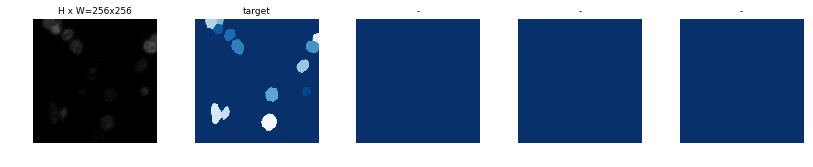

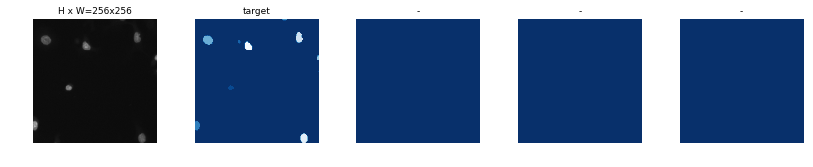

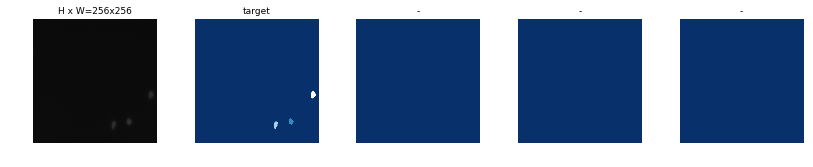

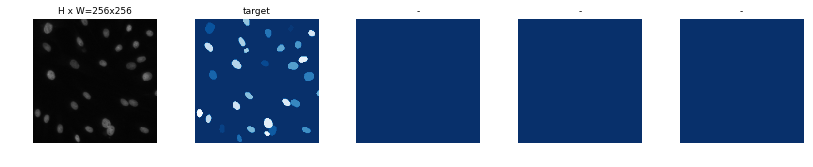

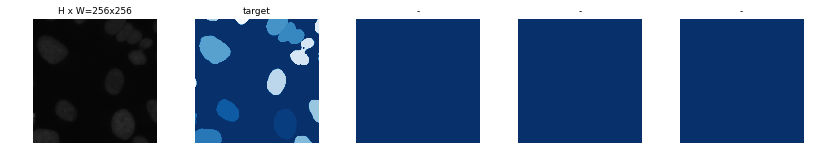

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.01

Checkpoint Path: /unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180208T1307/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
200/200 [==============================] - 299s 1s/step - loss: 1.0323 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.2394 - val_loss: 1.0649 - val_rpn_class_loss: 0.0695 - val_rpn_bbox_loss: 0.3558 - val_mrcnn_class_loss: 0.1955 - val_mrcnn_bbox_loss: 0.1979 - val_mrcnn_mask_loss: 0.2462
Epoch 2/10
200/200 [==============================] - 279s 1s/step - loss: 0.9611 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3683 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2331 - val_loss: 0.9653 - val_rpn_class_loss: 0.0611 - val_rpn_bbox_loss: 0.3281 - val_mrcnn_class_loss: 0.1519 - val_mrcnn_bbox_loss: 0.1751 - val_mrcnn_mask_loss: 0.2491
Epoch 3/10
200/200 [==============================] - 278s 1s/step - loss: 0.9123 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.3411 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2267 - val_loss: 0.9879 - val_rpn_class_l

In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=50, 
            layers="all")


Starting at epoch 10. LR=0.01

Checkpoint Path: /unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180208T1307/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/50
200/200 [==============================] - 317s 2s/step - loss: 0.8171 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.2932 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2168 - val_loss: 0.8945 - val_rpn_class_loss: 0.0411 - val_rpn_bbox_loss: 0.2846 - val_mrcnn_class_loss: 0.1681 - val_mrcnn_bbox_loss: 0.1657 - val_mrcnn_mask_loss: 0.2349
Epoch 12/50
200/200 [==============================] - 278s 1s/step - loss: 0.7644 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2122 - val_loss: 0.8211 - val_rpn_class_loss: 0.0362 - val_rpn_bbox_loss: 0.2534 - val_mrcnn_class_loss: 0.1607 - val_mrcnn_bbox_loss: 0.1503 - val_mrcnn_mask_loss: 0.2204
Epoch 13/50
200/200 [==============================] - 278s 1s/step - loss: 0.7436 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.2109 - val_loss: 0.7760 - val_rpn_clas

Epoch 33/50
200/200 [==============================] - 272s 1s/step - loss: 0.6230 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2019 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.1985 - val_loss: 0.7691 - val_rpn_class_loss: 0.0303 - val_rpn_bbox_loss: 0.2180 - val_mrcnn_class_loss: 0.1537 - val_mrcnn_bbox_loss: 0.1451 - val_mrcnn_mask_loss: 0.2219
Epoch 34/50
200/200 [==============================] - 275s 1s/step - loss: 0.6119 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1950 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1968 - val_loss: 0.7203 - val_rpn_class_loss: 0.0289 - val_rpn_bbox_loss: 0.2319 - val_mrcnn_class_loss: 0.1277 - val_mrcnn_bbox_loss: 0.1258 - val_mrcnn_mask_loss: 0.2060
Epoch 35/50
200/200 [==============================] - 275s 1s/step - loss: 0.6210 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.1982 - val_loss: 0.7017 - val_rpn_clas

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 50. LR=0.001

Checkpoint Path: /unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180208T1307/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/100
200/200 [==============================] - 315s 2s/step - loss: 0.5387 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1673 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1844 - val_loss: 0.6779 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 0.1809 - val_mrcnn_class_loss: 0.1270 - val_mrcnn_bbox_loss: 0.1210 - val_mrcnn_mask_loss: 0.2185
Epoch 52/100
200/200 [==============================] - 288s 1s/step - loss: 0.5343 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1852 - val_loss: 0.6642 - val_rpn_class_loss: 0.0308 - val_rpn_bbox_loss: 0.1802 - val_mrcnn_class_loss: 0.1293 - val_mrcnn_bbox_loss: 0.1189 - val_mrcnn_mask_loss: 0.2050
Epoch 53/100
200/200 [==============================] - 302s 2s/step - loss: 0.5286 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1640 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1834 - val_loss: 0.6839 - val_rpn_c

Epoch 73/100
200/200 [==============================] - 270s 1s/step - loss: 0.5052 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1797 - val_loss: 0.6981 - val_rpn_class_loss: 0.0301 - val_rpn_bbox_loss: 0.1784 - val_mrcnn_class_loss: 0.1331 - val_mrcnn_bbox_loss: 0.1305 - val_mrcnn_mask_loss: 0.2260
Epoch 74/100
200/200 [==============================] - 270s 1s/step - loss: 0.5051 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1795 - val_loss: 0.6947 - val_rpn_class_loss: 0.0309 - val_rpn_bbox_loss: 0.1793 - val_mrcnn_class_loss: 0.1186 - val_mrcnn_bbox_loss: 0.1328 - val_mrcnn_mask_loss: 0.2331
Epoch 75/100
200/200 [==============================] - 269s 1s/step - loss: 0.5039 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1548 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1797 - val_loss: 0.6529 - val_rpn_c

Epoch 95/100
200/200 [==============================] - 271s 1s/step - loss: 0.4947 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1521 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1782 - val_loss: 0.6735 - val_rpn_class_loss: 0.0323 - val_rpn_bbox_loss: 0.1849 - val_mrcnn_class_loss: 0.1130 - val_mrcnn_bbox_loss: 0.1309 - val_mrcnn_mask_loss: 0.2124
Epoch 96/100
200/200 [==============================] - 269s 1s/step - loss: 0.4960 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1518 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1785 - val_loss: 0.6661 - val_rpn_class_loss: 0.0324 - val_rpn_bbox_loss: 0.1827 - val_mrcnn_class_loss: 0.1083 - val_mrcnn_bbox_loss: 0.1162 - val_mrcnn_mask_loss: 0.2265
Epoch 97/100
200/200 [==============================] - 265s 1s/step - loss: 0.4901 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1505 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1769 - val_loss: 0.6714 - val_rpn_c

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=200, 
            layers="all")


Starting at epoch 100. LR=0.0001

Checkpoint Path: /unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180208T1307/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 101/200
200/200 [==============================] - 295s 1s/step - loss: 0.4858 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1766 - val_loss: 0.7052 - val_rpn_class_loss: 0.0351 - val_rpn_bbox_loss: 0.2058 - val_mrcnn_class_loss: 0.1372 - val_mrcnn_bbox_loss: 0.1185 - val_mrcnn_mask_loss: 0.2085
Epoch 102/200
200/200 [==============================] - 261s 1s/step - loss: 0.4863 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1483 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1776 - val_loss: 0.6780 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 0.2040 - val_mrcnn_class_loss: 0.1092 - val_mrcnn_bbox_loss: 0.1225 - val_mrcnn_mask_loss: 0.2077
Epoch 103/200
200/200 [==============================] - 262s 1s/step - loss: 0.4860 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1488 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1765 - val_loss: 0.7349 - val_rp

Epoch 123/200
200/200 [==============================] - 265s 1s/step - loss: 0.4837 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1491 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1762 - val_loss: 0.6910 - val_rpn_class_loss: 0.0347 - val_rpn_bbox_loss: 0.2015 - val_mrcnn_class_loss: 0.1223 - val_mrcnn_bbox_loss: 0.1259 - val_mrcnn_mask_loss: 0.2064
Epoch 124/200
127/200 [==================>...........] - ETA: 1:35 - loss: 0.4906 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1780

In [13]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [97]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
# model_path = '/unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180205T1645/mask_rcnn_shapes_0099.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /unsullied/sharefs/yuchenkai/storage/projects/Mask_RCNN/logs/shapes20180207T1242/mask_rcnn_shapes_0200.h5


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


original_image           shape: (256, 256, 3)         min:    0.07812  max:  109.48560
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (135,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (135, 4)              min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 135)       min:    0.00000  max:    1.00000


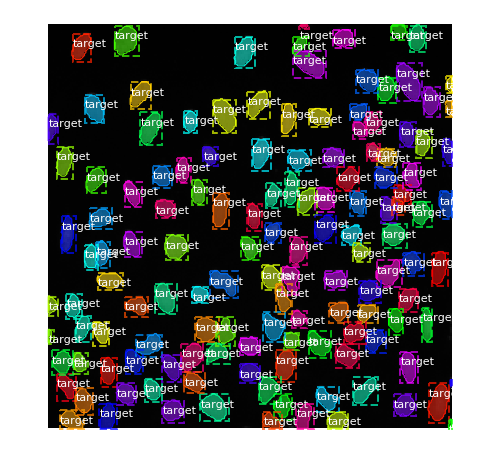

In [146]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.07812  max:  109.48560
molded_images            shape: (1, 256, 256, 3)      min: -123.62188  max:    5.58560
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


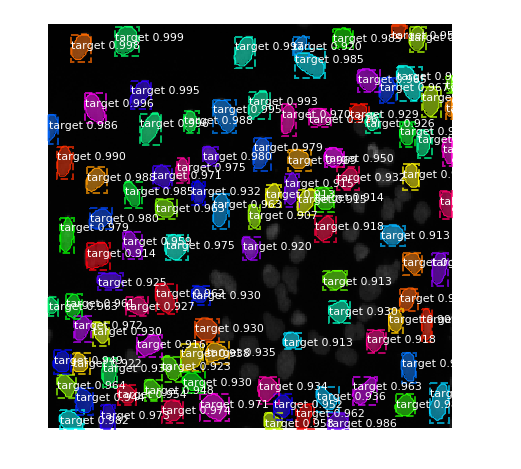

In [147]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [118]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 60)
APs = []
for image_id in tqdm(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)

print("mAP: ", np.mean(APs))

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 60/60 [00:40<00:00,  1.48it/s]

mAP:  0.854399716185


## Output Encoding

In [108]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

def combine(imgs):
    # print(imgs.max())
    imgs = imgs > 0.3
    # print(imgs.max())
    ret = np.zeros(tuple(imgs.shape[:2]), dtype=np.int32)
    for i in range(imgs.shape[2]):
        # print(imgs[:, :, i].shape, ret.shape)
        imgs[:, :, i] = np.logical_and(imgs[:, :, i], np.logical_not(ret))
        assert np.minimum(ret, imgs[:, :, i]).sum() == 0, np.minimum(ret, imgs[:, :, i]).sum()
        ret += imgs[:, :, i] * (i + 1)
    # plt.imshow(ret)
    # plt.show()
    return ret

def calc_tp(real_masks, pred_masks):
    # print(pred_masks.max())
    x = real_masks.max() + 1
    y = pred_masks.max() + 1
    matrix = np.zeros((x, y), dtype=np.int32)
    
    for i in range(real_masks.shape[0]):
        for j in range(real_masks.shape[1]):
            matrix[real_masks[i][j], pred_masks[i][j]] += 1
    
    matrix = matrix / (matrix.sum(axis=0, keepdims=True) + matrix.sum(axis=1, keepdims=True) - matrix)
    matrix = matrix[1:, 1:]
    return [(matrix > th).sum() for th in thresholds], x + y - 2

In [109]:
results = []
for i in tqdm(range(len(images_val))):
    results.extend(model.detect([dataset_val.load_image(i)]))

deno = []
domi = []
for i in tqdm(range(len(results))):
    result_mask = resize(results[i]['masks'], tuple(images_val[i].shape[:2]), preserve_range=True)
    
    tps, tot = calc_tp(combine(masks_val[i]), combine(result_mask))
    # print(tps, tot - tps)
    deno.append(tps)
    domi.append(tot - tps)
deno = np.array(deno).sum(axis=0)
domi = np.array(domi).sum(axis=0)
print((deno / domi).mean())

  0%|          | 0/67 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 67/67 [01:26<00:00,  1.29s/it]

0.460787235865


In [119]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

results = []
for i in tqdm(range(len(images_test))):
    results.extend(model.detect([dataset_test.load_image(i)]))

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 65/65 [00:10<00:00,  6.41it/s]


In [120]:
new_test_ids = []
rles = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    result_mask = resize(results[n]['masks'], tuple(images_test[n].shape[:2]), preserve_range=True)
    lab_img = combine(result_mask)
    for i in range(1, lab_img.max() + 1):
        rle = rle_encoding(lab_img == i)
        if len(rle) > 0:
            rles.append(rle)
            new_test_ids.append(id_)

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018_mrcnn.csv', index=False)

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 65/65 [00:33<00:00,  1.97it/s]


In [121]:
len(rles)

2776

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee


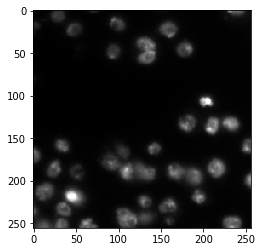

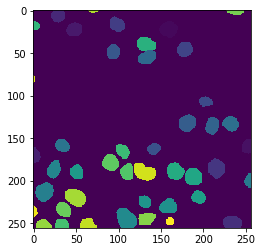

ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8


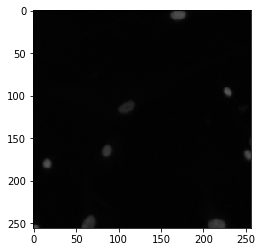

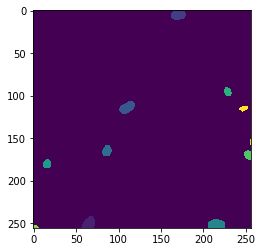

da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab


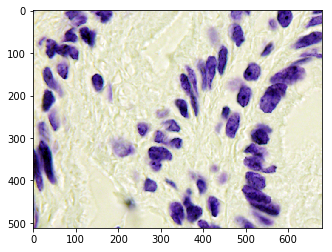

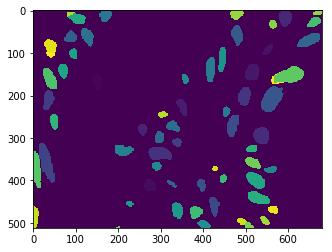

8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab


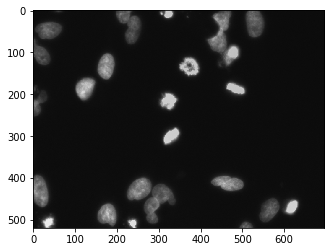

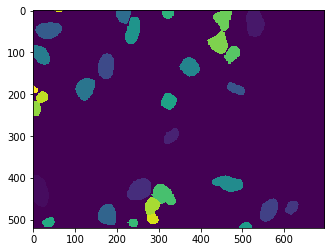

31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a


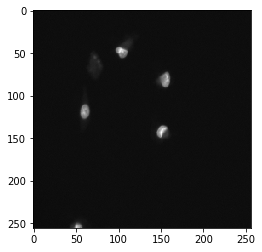

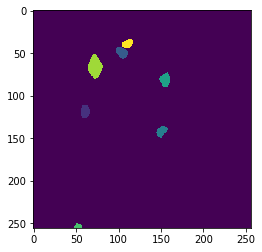

336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523


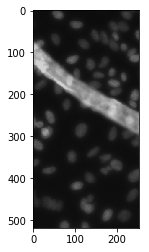

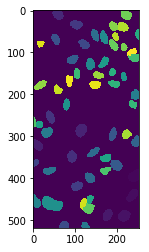

eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835


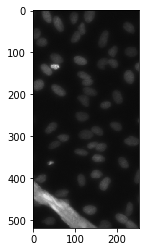

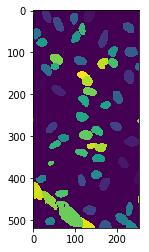

In [67]:
for i in range(5, 12):
    result_mask = resize(results[i]['masks'], tuple(images_test[i].shape[:2]), preserve_range=True)
    lab_img = combine(result_mask)
    print(test_ids[i])
    plt.imshow(images_test[i])
    plt.show()
    plt.imshow(lab_img)
    plt.show()